In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
digit_size = 28
n = 15 # Картинка с 15x15 цифр

def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator_in, generator_out, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])
            x_decoded = generator_out.eval(
                feed_dict={generator_in:z_sample})
            
            x_decoded = np.reshape(x_decoded, (28, 28))
            
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure


In [6]:
from IPython.display import clear_output
figs = []
latent_distrs = []
epochs = []

def on_epoch_end(epoch, test_batch):
    clear_output()
    n = 5
    imgs = mnist.test.images[:n]
    decoded = decoder_out.eval(feed_dict={x:imgs})
    plot_digits(np.reshape(imgs, (n, 28, 28, 1)), 
                np.reshape(decoded, (n, 28, 28, 1)))
    figure = draw_manifold(encoder_out, decoder_out, show=False)
    
    epochs.append(epoch)
    figs.append(figure)
    
    lat_vars = z_mean.eval(feed_dict={x:test_batch})
    
    latent_distrs.append(lat_vars)
        

In [4]:
##Leaky ReLU implementation
    
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [13]:
#model parameters
input_dim = 784
latent_dim = 2
batch_size = 256
dropout_rate = 0.1
num_classes = 10
summary_path = 'summary/train'
num_images = 55000



In [7]:
def vae_loss(x, decoded, z_mean, z_std):
    with tf.name_scope('loss'):
        with tf.name_scope('decoding_loss'):
            #dec_loss = tf.reduce_mean(tf.pow(x - decoded, 2))    
            #print(dec_loss.shape)
            dec_loss = \
            -tf.reduce_sum(x * tf.log(1e-6 + decoded)
                           + (1-x) * tf.log(1e-6 + 1 - decoded), 1)
            print(dec_loss.shape)
        
        with tf.name_scope('KL_loss'):
            kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)
                                 + tf.square(z_std)
                                 - tf.log(tf.square(z_std))
                                 - 1, 1)
            print(kl_loss.shape)

    return tf.reduce_mean(dec_loss + kl_loss)

In [8]:
def conditional_vae(image_in, label_in):
    with tf.name_scope('encoder'):
        
        encoder_in = tf.concat([image_in, label_in], 1)
        print(encoder_in.shape)
        
        y = tf.layers.dense(encoder_in, units=512, activation=tf.nn.relu,
                        bias_regularizer=tf.nn.l2_loss)
        y = tf.layers.dropout(y, dropout_rate)
        y = tf.layers.dense(y, units=256, activation=tf.nn.relu,
                       bias_regularizer=tf.nn.l2_loss)
    
        z_mean = tf.layers.dense(y, latent_dim)
        z_std = tf.layers.dense(y, latent_dim)  
        print(z_mean.shape)
    
    ###sampling and processing
    with tf.name_scope('sampling'):
        in_size = tf.shape(x)[0]
        sample = tf.random_normal([in_size, latent_dim], 0.0, 1.0)
        print(sample.shape)
        sampled = z_mean + (z_std * sample)
        encoder_out = sampled 
    ###
    
    with tf.name_scope('decoder'):
        decoder_in = tf.concat([encoder_out, label_in], 1)
        y = tf.layers.dense(decoder_in, units=256, activation=lrelu,
                       bias_regularizer=tf.nn.l2_loss)
        y = tf.layers.dropout(y, dropout_rate )
        y = tf.layers.dense(y, units=512, activation=lrelu,
                       bias_regularizer=tf.nn.l2_loss)
        y = tf.layers.dropout(y, dropout_rate )
        y = tf.layers.dense(y, units=input_dim, activation=tf.nn.sigmoid)
    
        decoder_out = y
        
    return encoder_out, z_mean, z_std, decoder_out

In [9]:
def vae(x):
    
    with tf.name_scope('encoder'):
        y = tf.layers.dense(x, units=512, activation=tf.nn.relu,
                        bias_regularizer=tf.nn.l2_loss)
        y = tf.layers.dropout(y, dropout_rate)
        y = tf.layers.dense(y, units=256, activation=tf.nn.relu,
                       bias_regularizer=tf.nn.l2_loss)
    
        z_mean = tf.layers.dense(y, latent_dim)
        z_std = tf.layers.dense(y, latent_dim)  
        print(z_mean.shape)
    
    ###sampling and processing
    with tf.name_scope('sampling'):
        in_size = tf.shape(x)[0]
        sample = tf.random_normal([in_size, latent_dim], 0.0, 1.0)
        print(sample.shape)
        sampled = z_mean + (z_std * sample)
        encoder_out = sampled 
    ###
    
    with tf.name_scope('decoder'):
        y = tf.layers.dense(encoder_out, units=256, activation=lrelu,
                       bias_regularizer=tf.nn.l2_loss)
        y = tf.layers.dropout(y, dropout_rate )
        y = tf.layers.dense(y, units=512, activation=lrelu,
                       bias_regularizer=tf.nn.l2_loss)
        y = tf.layers.dropout(y, dropout_rate )
        y = tf.layers.dense(y, units=input_dim, activation=tf.nn.sigmoid)
    
        decoder_out = y
        
    return encoder_out, z_mean, z_std, decoder_out

In [12]:
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

#input layer, starting point
x = tf.placeholder(tf.float32, shape=[None, input_dim], name='image_input') 
labels = tf.placeholder(tf.float32, shape=[None, num_classes], name='label_input')


encoder_out, z_mean, z_std, decoder_out = conditional_vae(x, labels)
#encoder_out, z_mean, z_std, decoder_out = vae(x)

loss = vae_loss(x, decoder_out, z_mean, z_std)
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

merged = tf.summary.merge_all()

sess.run(tf.global_variables_initializer())

train_writer = tf.summary.FileWriter(summary_path,
                                      sess.graph)

(?, 794)
(?, 2)
(?, 2)
(?,)
(?,)


In [19]:
#training procedure for conditional VAE
num_epochs = 20
val_batch_size = 256
steps_in_epoch = int(num_images / batch_size)
current_epoch = 0

figs = []
latent_distrs = []
epochs = []

test_batch = mnist.test.next_batch(val_batch_size)
test_imgs = test_batch[0]
test_labels = test_batch[1]

for i in range(num_epochs * steps_in_epoch):
    batch = mnist.train.next_batch(batch_size)
    sess.run([train_step], feed_dict={x: batch[0], labels: batch[1]})
   # train_writer.add_summary(summary, i)
    if (i % steps_in_epoch == 0) and (i > 0):
        current_epoch = current_epoch + 1
        
       # on_epoch_end(current_epoch, test_batch)
        
        test_loss = sess.run(loss, {x: test_imgs, labels: test_labels })
       # print('loss shape = ' + str(test_loss.shape))
        print('Epoch:' + str(current_epoch) + 
           #   '  train loss =  ' + str(sess.run(loss, feed_dict={x: mnist.train.images, y_: mnist.train.images})) + 
              '  test loss = ' + str(test_loss))

Epoch:1  test loss = 155.352
Epoch:2  test loss = 142.254
Epoch:3  test loss = 144.133
Epoch:4  test loss = 145.524
Epoch:5  test loss = 139.793
Epoch:6  test loss = 137.941
Epoch:7  test loss = 133.885
Epoch:8  test loss = 145.714
Epoch:9  test loss = 137.486
Epoch:10  test loss = 174.446
Epoch:11  test loss = 140.604
Epoch:12  test loss = 150.009
Epoch:13  test loss = 145.982
Epoch:14  test loss = 146.041
Epoch:15  test loss = 145.234
Epoch:16  test loss = 137.22
Epoch:17  test loss = 146.462
Epoch:18  test loss = 149.812
Epoch:19  test loss = 140.32


In [ ]:
#training procedure for simple VAE
num_epochs = 20
val_batch_size = 256
steps_in_epoch = int(num_images / batch_size)
current_epoch = 0

figs = []
latent_distrs = []
epochs = []

test_batch = mnist.test.next_batch(val_batch_size)[0]

for i in range(num_epochs * steps_in_epoch):
    batch = mnist.train.next_batch(batch_size)
    sess.run([train_step], feed_dict={x: batch[0]})
   # train_writer.add_summary(summary, i)
    if (i % steps_in_epoch == 0) and (i > 0):
        current_epoch = current_epoch + 1
        
       # on_epoch_end(current_epoch, test_batch)
        
        test_loss = sess.run(loss, {x: test_batch })
       # print('loss shape = ' + str(test_loss.shape))
        print('Epoch:' + str(current_epoch) + 
           #   '  train loss =  ' + str(sess.run(loss, feed_dict={x: mnist.train.images, y_: mnist.train.images})) + 
              '  test loss = ' + str(test_loss))

Epoch:1  test loss = 164.833
Epoch:2  test loss = 164.235
Epoch:3  test loss = 175.745
Epoch:4  test loss = 167.339
Epoch:5  test loss = 219.905
Epoch:6  test loss = 178.995
Epoch:7  test loss = 200.629
Epoch:8  test loss = 193.023
Epoch:9  test loss = 170.585
Epoch:10  test loss = 176.391
Epoch:11  test loss = 191.841
Epoch:12  test loss = 187.841
Epoch:13  test loss = 175.213
Epoch:14  test loss = 183.897


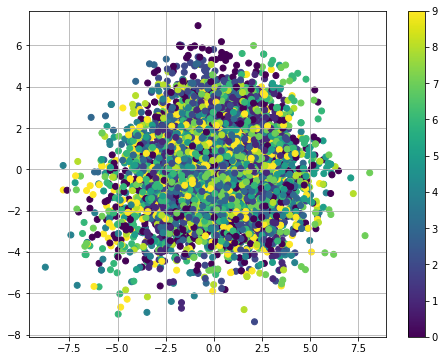

In [20]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = z_mean.eval(feed_dict={x:x_sample, labels:y_sample})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

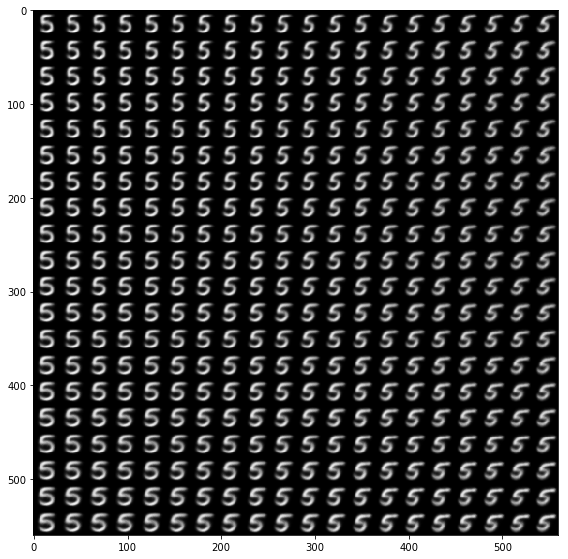

In [24]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*256)
        lbls = np.array([mnist.test.labels[3]] * 256)
        x_mean = decoder_out.eval(feed_dict={encoder_out:z_mu, labels:lbls})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [ ]:
test_batch = mnist.test.next_batch(val_batch_size)[0]
on_epoch_end(current_epoch, test_batch)